# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap

import shapefile

from geopy import distance

# Further imports for Polygon class
import random
import requests
import datetime
import time

import re

import pytz

# Polygon class

Let's have a new class for an object of type Polygon to help with the calculation steps. The Polygon will be defined by its bounding vertices and will have a number of methods to get random points and ETAs. I originally wrote this outside the notebook, but for the purposes of completeness, I have moved it here. Once the simulation is fleshed out into a proper app, this class should be moved to a new standalone file (as with all the other things in this notebook).

In [2]:
class Polygon:

    def __init__(self, vertices, reverse_lat_long=False):
        """
        vertices : list of tuples (latitude, longitude) as strings
        
        It is assumed that each vertex, in order, is joined 
        by a line to delineate the polygon.
        """
        self.vertices = np.array(vertices).astype(np.float)
        self.edges = self.make_edges(vertices)
        self.mins = np.amin(self.vertices, axis=0)
        self.maxs = np.amax(self.vertices, axis=0)
        self.vertices_strings = vertices
        self.reverse_lat_long = reverse_lat_long

    def make_edges(self, vertices):
        edges = list(zip(vertices, vertices[1:] + [vertices[0]]))
        return np.array(edges).astype(np.float)

    def get_random_point_within(self):
        line_origin = np.subtract(self.mins, 1.0)

        stop = False
        count = 0

        while stop == False:
            random_latitude = random.uniform(self.mins[0], self.maxs[0])
            random_longitude = random.uniform(self.mins[1], self.maxs[1])

            check_line = np.array([line_origin, [random_latitude, random_longitude]])

            intersections = np.zeros((self.edges.shape[0], 1))

            # Vectorisable?
            for i in range(0, self.edges.shape[0]):
                test_edge = self.edges[i, :, :]
                intersections[i] = self._intersects(check_line, test_edge)

            within = sum(list(map(self._bool_to_num, intersections))) % 2

            #print(count)
            #print((random_latitude, random_longitude))
            count += 1
            
            if within:
                stop = True

            if count > 100:
                raise ValueError("Failed to determine random point within polygon. Polygon may be too irregular.")

        str_lat = '{:.6f}'.format(random_latitude)
        str_long = '{:.6f}'.format(random_longitude)

        if self.reverse_lat_long:
            return (str_long, str_lat)
        else:
            return (str_lat, str_long)


    def generate_random_points_within(self, number, region_name=None):

        random_points = [{'region_name': region_name, 'origin_latitude': p[0], 'origin_longitude': p[1] } for p in map(lambda x: self.get_random_point_within(), range(number))]
        df = pd.DataFrame(random_points)

        # To save results to limit number of API calls
        filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        df.to_csv('points_{}.csv'.format(filename))
        return df

    def _bool_to_num(self, x):
        if x:
            return 1
        else:
            return 0

    def _intersects(self, line1, line2):
        # lines of form [[lat1 long1],[lat2 long2]]
        line1AB_line2A = ((line1[1][0] - line1[0][0]) * (line2[0][1] - line1[1][1])) - \
                         ((line2[0][0] - line1[1][0]) * (line1[1][1] - line1[0][1]))

        line1AB_line2B = ((line1[1][0] - line1[0][0]) * (line2[1][1] - line1[1][1])) - \
                         ((line2[1][0] - line1[1][0]) * (line1[1][1] - line1[0][1]))

        line2AB_line1A = ((line2[1][0] - line2[0][0]) * (line1[0][1] - line2[1][1])) - \
                         ((line1[0][0] - line2[1][0]) * (line2[1][1] - line2[0][1]))

        line2AB_line1B = ((line2[1][0] - line2[0][0]) * (line1[1][1] - line2[1][1])) - \
                         ((line1[1][0] - line2[1][0]) * (line2[1][1] - line2[0][1]))

        if (line1AB_line2A * line1AB_line2B) < 0 and (line2AB_line1A * line2AB_line1B) < 0:
            return True

        return False


# Victoria

## Data Sourcing

Potential sources of data include:

- [PSMA Administrative Boundaries](https://data.gov.au/dataset/vic-local-government-areas-psma-administrative-boundaries). Data of various boundary types including, as described, "Australian Bureau of Statistics (ABS) boundaries, electoral boundaries, state and territory boundaries, local government areas, suburbs/localities, wards and town points."
- [Victorian Spacial Datamart](http://services.land.vic.gov.au/SpatialDatamart/createAllOrders.html). Includes boundaries of different area types such as Local Government Area, Postcode and Localities, though limited to 15 elements per order.
- [ABS Census DataPacks and GeoPacks](https://datapacks.censusdata.abs.gov.au/). Contains data, integrated with boundary data in the case of GeoPacks, from census data collected by the ABS. DataPacks also contain a link to ESRI Shapefiles for region boundaries.

For this notebook, the data sourced was **VIC State Electoral Divisions** (SEDs) from the ABS Census DataPack.

## Examining the Shape Data

In [13]:
external_data_dir = '../data/external/2016_SED_shape/'
filename_base = 'SED_2016_AUST'

First having a brief look at what the data contains.

In [4]:
shape_data = shapefile.Reader(external_data_dir + filename_base)
all_shapes = shape_data.shapeRecords()

Some basic information on the data:

In [5]:
len(all_shapes)

448

In [6]:
all_shapes[0].record

['SED10001', '10001', 'Albury', '1', 'New South Wales', 19487.8]

Let's filter the data to only include Victoria SEDs.

In [7]:
vic_shapes = [shape for shape in all_shapes if shape.record[4] == 'Victoria' ]

Now let's look at the SED names.

In [8]:
len(vic_shapes)

90

In [38]:
for shape in vic_shapes:
    print(shape.record[2])

Albert Park (Southern Metropolitan)
Altona (Western Metropolitan)
Bass (Eastern Victoria)
Bayswater (Eastern Metropolitan)
Bellarine (Western Victoria)
Benambra (Northern Victoria)
Bendigo East (Northern Victoria)
Bendigo West (Northern Victoria)
Bentleigh (Southern Metropolitan)
Box Hill (Eastern Metropolitan)
Brighton (Southern Metropolitan)
Broadmeadows (Northern Metropolitan)
Brunswick (Northern Metropolitan)
Bulleen (Eastern Metropolitan)
Bundoora (Northern Metropolitan)
Buninyong (Western Victoria)
Burwood (Southern Metropolitan)
Carrum (South-Eastern Metropolitan)
Caulfield (Southern Metropolitan)
Clarinda (South-Eastern Metropolitan)
Cranbourne (South-Eastern Metropolitan)
Croydon (Eastern Metropolitan)
Dandenong (South-Eastern Metropolitan)
Eildon (Northern Victoria)
Eltham (Eastern Metropolitan)
Essendon (Western Metropolitan)
Euroa (Northern Victoria)
Evelyn (Eastern Victoria)
Ferntree Gully (Eastern Metropolitan)
Footscray (Western Metropolitan)
Forest Hill (Eastern Metropo

On a plot, exluding the two last list elements:

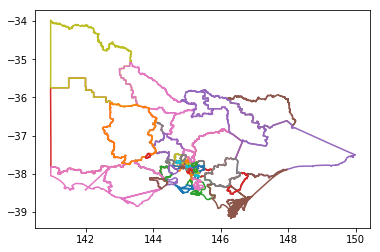

In [10]:
plt.figure()
for shape in vic_shapes[:-2]:
    all_points = shape.shape.points
    #if re.match(r".*Metropolitan.*", shape.record[2]):
    x = [point[0] for point in all_points]
    y = [point[1] for point in all_points]
    plt.plot(x, y)

## Examining Census Data

In [14]:
external_census_dir = '../data/external/2016_GCP_SED_for_Vic_short-header/2016 Census GCP State Electoral Divisions for VIC/'
census_data_files = os.listdir(external_census_dir)

From the Metadata file, the data for "Selected Person Characteristics by Sex" is contained in Table Number G01, which likely contains the overall total amount of people for each LGA.

In [15]:
g01_data = pd.read_csv(external_census_dir + '2016Census_G01_VIC_SED.csv')

In [16]:
g01_data[0:5]

,SED_CODE_2016,Tot_P_M,Tot_P_F,Tot_P_P,Age_0_4_yr_M,Age_0_4_yr_F,Age_0_4_yr_P,Age_5_14_yr_M,Age_5_14_yr_F,Age_5_14_yr_P,...,High_yr_schl_comp_Yr_8_belw_P,High_yr_schl_comp_D_n_g_sch_M,High_yr_schl_comp_D_n_g_sch_F,High_yr_schl_comp_D_n_g_sch_P,Count_psns_occ_priv_dwgs_M,Count_psns_occ_priv_dwgs_F,Count_psns_occ_priv_dwgs_P,Count_Persons_other_dwgs_M,Count_Persons_other_dwgs_F,Count_Persons_other_dwgs_P
0,SED20106,37542,38414,75951,1680,1698,3380,2197,2120,4314,...,1566,145,211,355,31866,33295,65160,7385,6939,14328
1,SED20207,45554,46137,91695,4267,4009,8276,6682,6268,12955,...,3170,298,410,705,42931,43556,86484,2099,2134,4234
2,SED20302,35313,37386,72701,2720,2560,5277,4992,4864,9859,...,3434,128,142,273,32152,33998,66153,2417,2776,5196
3,SED20401,30328,31860,62184,2138,2063,4205,3621,3388,7013,...,2269,153,178,335,28310,29481,57789,1476,1879,3353
4,SED20508,28565,30653,59222,1759,1596,3357,3768,3605,7376,...,2496,77,56,130,25700,27668,53366,1648,1911,3560


We just need to pay attention to the column `Tot_P_P` (total persons) (along with `LGA_CODE_2016`).

In [17]:
sum(g01_data.Tot_P_P)

5926617

This is a pretty reasonable estimate for the population of Victoria, so we'll go ahead with it.

## Hospital (Destination) Coordinates

We need data of the coordinates of each hospital. Using the `TestApplications` list of hospitals, I used [a free service](www.gps-coordinates.net) to map each hospital address to their corresponding coordinate with the information below.

In [108]:
hospitals = [
    {"name": "Austin Health", "identifier": "austinhealth", "address": "145 Studley Rd, Heidelberg VIC 3084"},
    {"name": "Monash Health", "identifier": "monashhealth", "address": "246 Clayton Rd, Clayton VIC 3168"},
    {"name": "Royal Melbourne Hospital", "identifier": "rmh", "address": "The Royal Melbourne Hospital, 300 Grattan St, Parkville VIC 3052"},
    {"name": "The Alfred", "identifier": "thealfred", "address": "The Alfred Hospital, 55 Commercial Rd, Melbourne VIC 3004"},
    {"name": "Box Hill Hospital", "identifier": "boxhillhospital", "address": "Box Hill Hospital, 5 Arnold St"},
    {"name": "Dandenong Hospital", "identifier": "dandenonghospital", "address": "Dandenong Hospital: Emergency Department, David Street, Dandenong VIC, Australia"},
    {"name": "Footscray Hospital", "identifier": "footscrayhospital", "address": "Footscray Hospital, 160 Gordon St, Footscray VIC 3011"},
    {"name": "Frankston Hospital", "identifier": "frankstonhospital", "address": "Frankston Hospital : Emergency Department, Hastings Road, Frankston VIC, Australia"},
    {"name": "The Northern Hospital", "identifier": "thenorthernhospital", "address": "The Northern Hospital: Emergency Department, Cooper Street, Epping VIC, Australia"},
    {"name": "Peninsula Health", "identifier": "peninsulahealth", "address": "Rosebud Hospital: Emergency Department, Point Nepean Road, Capel Sound VIC, Australia"},
    {"name": "St Vincent's Hospital", "identifier": "stvincentshospital", "address": "41 Victoria Parade, Fitzroy VIC 3065, Australia"},
    {"name": "Sunshine Hospital", "identifier": "sunshinehospital", "address": "Sunshine Hospital: Emergency Room, Furlong Road, Saint Albans VIC, Australia"},
    {"name": "Albury Wodonga Health", "identifier": "alburywodongahealth", "address": "Albury Wodonga Health, Wodonga Campus, Vermont Street, Wodonga VIC, Australia"},
    {"name": "Bairnsdale Regional Health", "identifier": "bairnsdaleregionalhealth", "address": "Bairnsdale Regional Health Service, Bairnsdale VIC, Australia"},
    {"name": "Ballarat Health", "identifier": "ballarathealth", "address": "Ballarat Health Services, Drummond Street North, Ballarat Central VIC, Australia"},
    {"name": "Barwon Health", "identifier": "barwonhealth", "address": "University Hospital Geelong, Barwon Health, Bellerine Street, Geelong VIC, Australia"},
    {"name": "Bendigo Health Care Group", "identifier": "bendigohealth", "address": "Bendigo Health, Barnard Street, Bendigo VIC, Australia"},
    {"name": "Echuca Regional Health", "identifier": "echucaregionalhealth", "address": "Echuca Regional Health: Emergency Department, Service Street, Echuca VIC, Australia"},
    {"name": "Goulburn Valley Health", "identifier": "goulburnvalleyhealth", "address": "Goulburn Valley Health - Emergency Department, Graham Street, Shepparton VIC, Australia"},
    {"name": "Melton Health", "identifier": "meltonhealth", "address": "Melton Health Services, Barries Road, Melton West VIC, Australia"},
    {"name": "Mildura Base Hospital", "identifier": "mildurabasehospital", "address": "Mildura Base Hospital : Emergency Room, Ontario Avenue, Mildura VIC, Australia"},
    {"name": "Northeast Health Wangaratta", "identifier": "northeasthealth", "address": "Northeast Health Wangaratta: Emergency Department, Green Street, Wangaratta VIC, Australia"},
    {"name": "Swan Hill District Health", "identifier": "swanhilldistricthealth", "address": "Swan Hill District Health: Emergency Room, Splatt Street, Swan Hill VIC, Australia"},
    {"name": "Wimmera Health Care Group", "identifier": "wimmerahealth", "address": "Wimmera Health Care Group, Baillie Street, Horsham VIC, Australia"}
]

Now calling the free API for each bookmarked location:

In [ ]:
url = 'http://www.gps-coordinates.net/api/'

for hospital_dict in hospitals:
    response = requests.get(url + hospital_dict['identifier'])
    data = response.json()
    if data['responseCode'] == '200':
        hospital_dict['latitude'] = data['latitude']
        hospital_dict['longitude'] = data['longitude']
    else:
        print('{} failed to retrieve coordinates.'.format(hospital_dict['name']))

In [ ]:
hospital_data = pd.DataFrame(hospitals)

In [12]:
hospital_data

,Unnamed: 0,address,identifier,latitude,longitude,name
0,0,"145 Studley Rd, Heidelberg VIC 3084",austinhealth,-37.756676,145.059250,Austin Health
1,1,"246 Clayton Rd, Clayton VIC 3168",monashhealth,-37.920377,145.123969,Monash Health
2,2,"The Royal Melbourne Hospital, 300 Grattan St, ...",rmh,-37.799323,144.956691,Royal Melbourne Hospital
3,3,"The Alfred Hospital, 55 Commercial Rd, Melbour...",thealfred,-37.845670,144.981920,The Alfred
4,4,"Box Hill Hospital, 5 Arnold St",boxhillhospital,-37.814519,145.118453,Box Hill Hospital
5,5,"Dandenong Hospital: Emergency Department, Davi...",dandenonghospital,-37.976896,145.219547,Dandenong Hospital
6,6,"Footscray Hospital, 160 Gordon St, Footscray V...",footscrayhospital,-37.792198,144.886918,Footscray Hospital
7,7,"Frankston Hospital : Emergency Department, Has...",frankstonhospital,-38.149687,145.127675,Frankston Hospital
8,8,"The Northern Hospital: Emergency Department, C...",thenorthernhospital,-37.653196,145.015073,The Northern Hospital
9,9,"Rosebud Hospital: Emergency Department, Point ...",peninsulahealth,-38.362104,144.884681,Peninsula Health


In [112]:
hospital_data.to_csv('../data/processed/hospital_data.csv')

Now that we've generated the data, we can just load it here instead:

In [11]:
hospital_data = pd.read_csv('../data/processed/hospital_data.csv')

## Getting Random Points

Let's try to get random points. Let's say we have a budget of 100 USD and, with an estimated cost of 0.01 USD per element, 90 SEDs and 2 hospitals per random point for 5 time points, we can get the following number of samples.

In [18]:
100 / (0.01 * 90 * 2 * 5)

11.11111111111111

So let's sample 10 random points per SED.

Our process will be:
1. Determine a random point within the SED boundary
2. Find the two closest hospitals to that random point
3. Find the distance matrix of that point with those two closest hospitals for each of the 5 specified times.
4. Save the returned result.

Let's define a function that returns the two closest hospitals to a given coordinate. 

In [19]:
def hosp_by_dist(latitude, longitude):
    new_df = hospital_data
    new_df['distances'] = hospital_data.apply(lambda x: distance.distance((latitude, longitude),
                                                                (x['latitude'], x['longitude'])).km, 
                                    axis=1)
    sorted_df = new_df.sort_values(by=['distances'])
    return sorted_df    

Now turning this into a script:

In [20]:
with open('./google_maps_api_key.txt') as infile:
    google_maps_api_key = infile.read().rstrip()

In [40]:
num_samples = 10

In [29]:
departure_times = [
    "2019-03-19 09:00",
    "2019-03-19 13:00",
    "2019-03-19 17:00",
    "2019-03-19 21:00",
    "2019-03-19 00:00"
]

In [30]:
def classify_locality(name):
    if re.match(r".*Metro.*", name):
        return "metropolitan"
    else:
        return "rural"

In [31]:
aest = pytz.timezone("Australia/Melbourne")
departure_times_unix = list(map(lambda x: str(int(time.mktime(aest.localize(datetime.datetime.strptime(x,
                                                       '%Y-%m-%d %H:%M')).timetuple()))), departure_times))

In [32]:
departure_times_unix

['1552946400', '1552960800', '1552975200', '1552989600', '1552914000']

In [41]:
error_count = 0

for shape in vic_shapes[:-2]: # excluding No usual address and migratory/offshore/shipping
    region_polygon = Polygon(shape.shape.points, reverse_lat_long=True)
    etas = []
    for n in range(num_samples):

        origin_coords = region_polygon.get_random_point_within()
        ori_str = ','.join(origin_coords)

        hosps = hosp_by_dist(origin_coords[0], origin_coords[1])
        closest = hosps[:2]
        dest_str_list = [','.join((str(x[1]['latitude']), str(x[1]['longitude']))) for x in closest.iterrows()]
        dest_str = '|'.join(dest_str_list)
            
        for dt_index, departure_time in enumerate(departure_times_unix):

            url = 'https://maps.googleapis.com/maps/api/distancematrix/json'

            payload = {'mode': 'driving',
                       'origins': ori_str,
                       'destinations': dest_str,
                       'key': google_maps_api_key,
                       'departure_time': departure_time
                    }

            response = requests.get(url, params=payload)
            data = response.json()

            # Vectorise?
            for i, row in enumerate(data.get('rows')): # corresponds to origins
                entry = {}
                entry['sed_id'] = shape.record[0]
                entry['sed_name'] = shape.record[2]
                entry['origin_latitude'] = origin_coords[0]
                entry['origin_longitude'] = origin_coords[1]
                entry['departure_datetime_unix'] = departure_time
                entry['departure_datetime_string'] = departure_times[dt_index]
                entry['type'] = classify_locality(shape.record[2])
                all_destinations = {}
                entry['raw_data'] = data
                for j, element in enumerate(row.get('elements')): # corresponds to destination
                    if element.get('status') == 'OK':
                        all_destinations[closest.iloc[j].get('name')] = element.get('duration_in_traffic').get('value') # in seconds
                    else:
                        print(element.get('status'))
                        all_destinations[closest.iloc[j].get('name')] = None
                entry['all_destinations'] = all_destinations
                try:
                    entry['closest_time_to_arrival'] = min(all_destinations.values())
                    entry['closest_destination'] = min(all_destinations, key=all_destinations.get)
                    entry['second_closest_time_to_arrival'] = max(all_destinations.values())
                    entry['second_closest_destination'] = max(all_destinations, key=all_destinations.get)
                except TypeError: # NoneType comparison
                    entry['closest_time_to_arrival'] = None
                    entry['closest_destination'] = None
                    entry['second_closest_time_to_arrival'] = None
                    entry['second_closest_destination'] = None

                    error_count += 1
                    print("ERROR occurred, continuing.")
                etas.append(entry)

    df = pd.DataFrame(etas)

    # To save results to limit number of API calls
    filename = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    df.to_csv('../data/processed/traveltimes/with_departure_time/traveltimes_{}_{}.csv'.format(shape.record[0], filename))
    
    print("{} DONE".format(shape.record[2]))
print(error_count)

Albert Park (Southern Metropolitan) DONE
Altona (Western Metropolitan) DONE
Bass (Eastern Victoria) DONE
Bayswater (Eastern Metropolitan) DONE
Bellarine (Western Victoria) DONE
Benambra (Northern Victoria) DONE
Bendigo East (Northern Victoria) DONE
Bendigo West (Northern Victoria) DONE
Bentleigh (Southern Metropolitan) DONE
Box Hill (Eastern Metropolitan) DONE
Brighton (Southern Metropolitan) DONE
Broadmeadows (Northern Metropolitan) DONE
Brunswick (Northern Metropolitan) DONE
Bulleen (Eastern Metropolitan) DONE
Bundoora (Northern Metropolitan) DONE
Buninyong (Western Victoria) DONE
Burwood (Southern Metropolitan) DONE
Carrum (South-Eastern Metropolitan) DONE
Caulfield (Southern Metropolitan) DONE
Clarinda (South-Eastern Metropolitan) DONE
Cranbourne (South-Eastern Metropolitan) DONE
Croydon (Eastern Metropolitan) DONE
Dandenong (South-Eastern Metropolitan) DONE
Eildon (Northern Victoria) DONE
Eltham (Eastern Metropolitan) DONE
Essendon (Western Metropolitan) DONE
Euroa (Northern Victo

# Plotting Random Points

## Victoria as a Whole

In [42]:
base_dir = '../data/processed/traveltimes/with_departure_time/'
vic_data = list(map(lambda x: pd.read_csv(base_dir + x), os.listdir(base_dir)))

In [48]:
def plot_points(zoom_scale): # relies on global variables vic_data, hospital_data
    centre = [-37.8, 145]
    bbox = [centre[0]-zoom_scale, centre[0]+zoom_scale,
            centre[1]-zoom_scale, centre[1]+zoom_scale]

    plt.figure(figsize=(12,12))
    m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],
                llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')
    m.drawcoastlines()
    m.fillcontinents(alpha=0.2)
    m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
    m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=90)
    m.drawmapboundary(fill_color='white')

    def convert(origin_latitude, origin_longitude):
        return m(origin_longitude, origin_latitude)

    m_coords = []

    for i, d in enumerate(vic_data):
        m_coords.append(d[['origin_latitude','origin_longitude']].apply(lambda x: convert(*x), axis=1))

    for i, cs in enumerate(m_coords):
        xs = [c[0] for c in cs]
        ys = [c[1] for c in cs]
        m.scatter(xs,ys,marker='D',c=np.random.rand(3), s=4)

    hosp_coords = hospital_data[['latitude', 'longitude']].apply(lambda x: convert(*x), axis=1)
    for i, c in enumerate(hosp_coords):
        min_c = convert(bbox[0], bbox[2])
        max_c = convert(bbox[1], bbox[3])
        if c[0] > min_c[0] and c[0] < max_c[0] and c[1] > min_c[1] and c[1] < max_c[1]:
            m.plot(c[0], c[1], 'r*')
            plt.text(c[0], c[1], hospital_data.iloc[i]['name'], fontsize=12)


    plt.show()

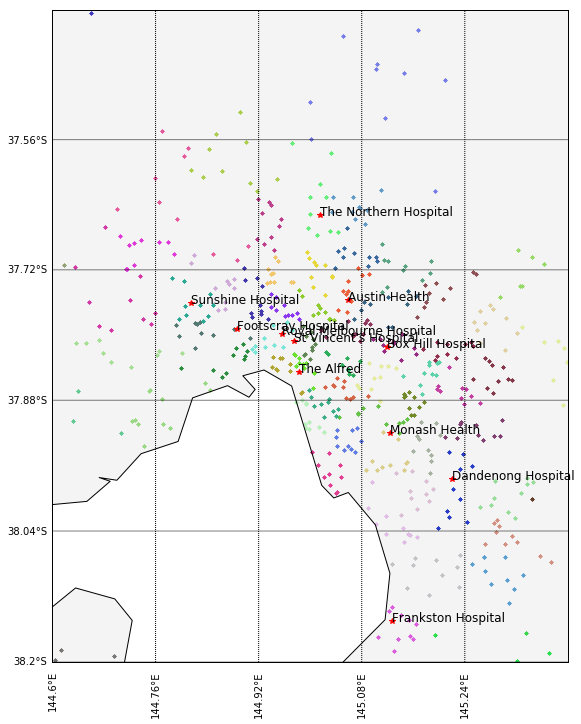

In [51]:
plot_points(0.4)

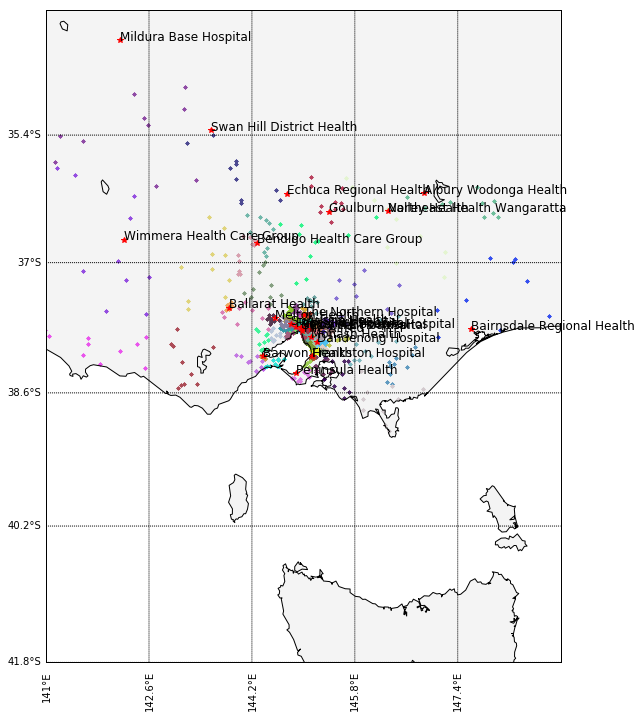

In [50]:
plot_points(4)